# Sanity Check of FedLeak, ImageNet(ISLVRC2012).

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***ImageNet(ISLVRC2012)***, with $5$ times sampling batch = $16$, reporting results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from test-set, with `shuffle=True`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_showcase.ipynb`, with `generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
# ⚠️ WARNING:
# ⚠️ Here we make a monkey patch for tqdm, removing the progress bar of training in consoles.
# ⚠️ Since it would make the output of cell very messy if we run it with `run_notebook.py`.
# ⚠️ 
# ⚠️ Set `need_tqdm_monkey_patch` as `False` to forbid this behaviour, especially when you
# ⚠️ directly run this jupyter notebook, rather than executing with `run_notebook.py`.
need_tqdm_monkey_patch = True
if need_tqdm_monkey_patch:
    import tqdm
    _real_tqdm = tqdm.tqdm

    def _silent_tqdm(*args, **kwargs):
        kwargs["disable"] = True
        return _real_tqdm(*args, **kwargs)

    tqdm.tqdm = _silent_tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [3]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:2")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageNet(root="~/data/imagenet/", split="val", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=2)

### 🚩 3. Attack for five times

In [4]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

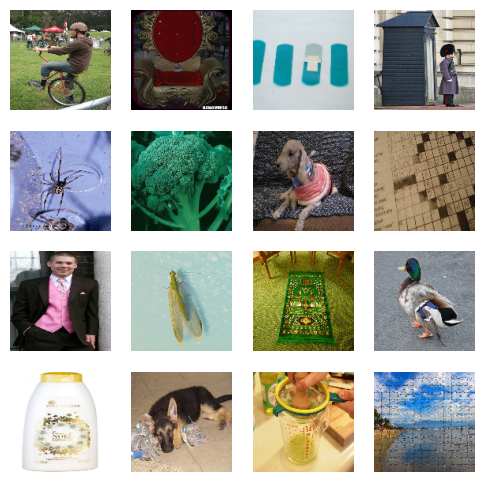

| It: 1 | Loss: -13.7079 | Time:   5.22s |


| It: 1001 | Loss: -61.1587 | Time: 564.17s |


| It: 2001 | Loss: -61.6559 | Time: 564.49s |


| It: 3001 | Loss: -61.7818 | Time: 564.62s |


| It: 4001 | Loss: -61.8442 | Time: 566.40s |


| It: 5001 | Loss: -61.8875 | Time: 565.63s |


| It: 6001 | Loss: -61.9183 | Time: 565.22s |


| It: 7001 | Loss: -61.9398 | Time: 562.87s |


| It: 8001 | Loss: -61.9534 | Time: 564.33s |


| It: 9001 | Loss: -61.9600 | Time: 562.78s |


| It: 1 | Loss: -3.6935 | Time:   0.61s |


| It: 1001 | Loss: -61.2274 | Time: 565.50s |


| It: 2001 | Loss: -61.6601 | Time: 563.86s |


| It: 3001 | Loss: -61.7896 | Time: 562.08s |


| It: 4001 | Loss: -61.8404 | Time: 564.96s |


| It: 5001 | Loss: -61.8882 | Time: 562.65s |


| It: 6001 | Loss: -61.9180 | Time: 561.35s |


| It: 7001 | Loss: -61.9408 | Time: 563.18s |


| It: 8001 | Loss: -61.9538 | Time: 563.18s |


| It: 9001 | Loss: -61.9603 | Time: 563.00s |


| It: 1 | Loss: -0.1693 | Time:   0.57s |


| It: 1001 | Loss: -61.0523 | Time: 563.21s |


| It: 2001 | Loss: -61.6551 | Time: 564.27s |


| It: 3001 | Loss: -61.7803 | Time: 563.52s |


| It: 4001 | Loss: -61.8444 | Time: 563.49s |


| It: 5001 | Loss: -61.8877 | Time: 561.03s |


| It: 6001 | Loss: -61.9160 | Time: 563.22s |


| It: 7001 | Loss: -61.9384 | Time: 563.68s |


| It: 8001 | Loss: -61.9521 | Time: 564.87s |


| It: 9001 | Loss: -61.9586 | Time: 564.57s |


| It: 1 | Loss: -8.6235 | Time:   0.41s |


| It: 1001 | Loss: -61.0508 | Time: 562.55s |


| It: 2001 | Loss: -61.6261 | Time: 563.42s |


| It: 3001 | Loss: -61.7690 | Time: 563.47s |


| It: 4001 | Loss: -61.8405 | Time: 564.34s |


| It: 5001 | Loss: -61.8812 | Time: 565.17s |


| It: 6001 | Loss: -61.9127 | Time: 563.84s |


| It: 7001 | Loss: -61.9359 | Time: 563.67s |


| It: 8001 | Loss: -61.9502 | Time: 562.67s |


| It: 9001 | Loss: -61.9570 | Time: 564.55s |


| It: 1 | Loss: -10.2584 | Time:   0.63s |


| It: 1001 | Loss: -60.8943 | Time: 561.37s |


| It: 2001 | Loss: -61.6123 | Time: 563.29s |


| It: 3001 | Loss: -61.7684 | Time: 563.06s |


| It: 4001 | Loss: -61.8316 | Time: 563.35s |


| It: 5001 | Loss: -61.8759 | Time: 562.15s |


| It: 6001 | Loss: -61.9095 | Time: 563.43s |


| It: 7001 | Loss: -61.9343 | Time: 558.05s |


| It: 8001 | Loss: -61.9486 | Time: 564.51s |


| It: 9001 | Loss: -61.9557 | Time: 562.16s |


BEST PSNR: 21.0622
MEDIAN PSNR: 20.5418
ALL PSNR: [20.5682, 21.0622, 20.7789, 20.5621, 20.5621]


<Figure size 400x300 with 0 Axes>

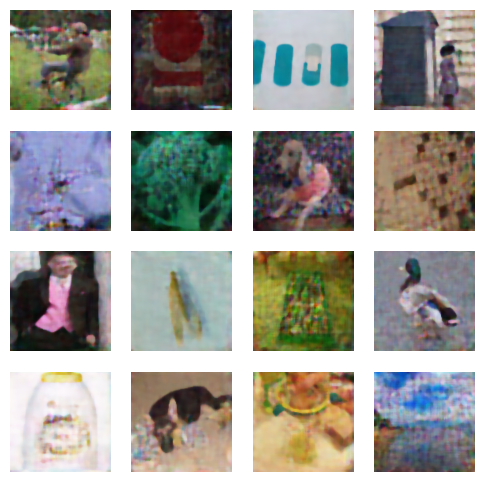

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

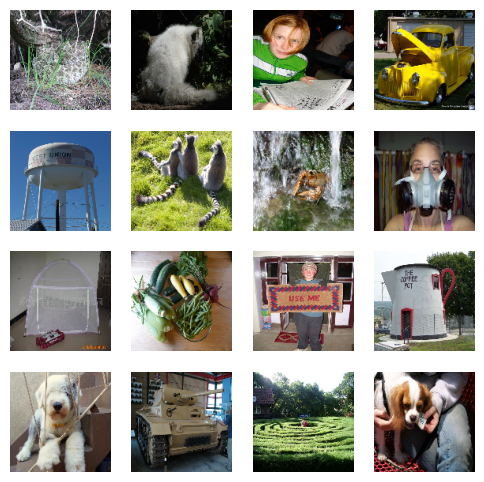

| It: 1 | Loss: -5.5714 | Time:   0.58s |


| It: 1001 | Loss: -61.0572 | Time: 561.96s |


| It: 2001 | Loss: -61.6432 | Time: 564.30s |


| It: 3001 | Loss: -61.7792 | Time: 564.18s |


| It: 4001 | Loss: -61.8471 | Time: 563.56s |


| It: 5001 | Loss: -61.8885 | Time: 563.84s |


| It: 6001 | Loss: -61.9195 | Time: 562.68s |


| It: 7001 | Loss: -61.9428 | Time: 563.45s |


| It: 8001 | Loss: -61.9558 | Time: 560.83s |


| It: 9001 | Loss: -61.9622 | Time: 560.32s |


| It: 1 | Loss: -9.1197 | Time:   0.39s |


| It: 1001 | Loss: -60.7372 | Time: 353.20s |


| It: 2001 | Loss: -61.5830 | Time: 344.19s |


| It: 3001 | Loss: -61.7502 | Time: 352.77s |


| It: 4001 | Loss: -61.8288 | Time: 354.53s |


| It: 5001 | Loss: -61.8769 | Time: 355.46s |


| It: 6001 | Loss: -61.9132 | Time: 355.31s |


| It: 7001 | Loss: -61.9364 | Time: 354.52s |


| It: 8001 | Loss: -61.9510 | Time: 353.90s |


| It: 9001 | Loss: -61.9580 | Time: 354.24s |


| It: 1 | Loss: -7.9483 | Time:   0.39s |


| It: 1001 | Loss: -60.6034 | Time: 356.45s |


| It: 2001 | Loss: -61.5361 | Time: 355.71s |


| It: 3001 | Loss: -61.7262 | Time: 357.09s |


| It: 4001 | Loss: -61.8088 | Time: 355.15s |


| It: 5001 | Loss: -61.8623 | Time: 355.81s |


| It: 6001 | Loss: -61.9032 | Time: 354.64s |


| It: 7001 | Loss: -61.9288 | Time: 355.46s |


| It: 8001 | Loss: -61.9452 | Time: 355.86s |


| It: 9001 | Loss: -61.9528 | Time: 353.98s |


| It: 1 | Loss: -12.6018 | Time:   0.37s |


| It: 1001 | Loss: -61.1408 | Time: 353.26s |


| It: 2001 | Loss: -61.6563 | Time: 354.37s |


| It: 3001 | Loss: -61.7841 | Time: 348.62s |


| It: 4001 | Loss: -61.8443 | Time: 356.16s |


| It: 5001 | Loss: -61.8878 | Time: 354.51s |


| It: 6001 | Loss: -61.9208 | Time: 354.49s |


| It: 7001 | Loss: -61.9424 | Time: 353.92s |


| It: 8001 | Loss: -61.9564 | Time: 354.32s |


| It: 9001 | Loss: -61.9625 | Time: 353.90s |


| It: 1 | Loss: -5.5206 | Time:   0.38s |


| It: 1001 | Loss: -60.9801 | Time: 351.10s |


| It: 2001 | Loss: -61.6304 | Time: 353.47s |


| It: 3001 | Loss: -61.7708 | Time: 352.73s |


| It: 4001 | Loss: -61.8430 | Time: 354.92s |


| It: 5001 | Loss: -61.8873 | Time: 351.76s |


| It: 6001 | Loss: -61.9197 | Time: 353.19s |


| It: 7001 | Loss: -61.9415 | Time: 354.03s |


| It: 8001 | Loss: -61.9553 | Time: 354.24s |


| It: 9001 | Loss: -61.9617 | Time: 352.81s |


BEST PSNR: 19.6266
MEDIAN PSNR: 19.3291
ALL PSNR: [19.6266, 19.4398, 18.8312, 19.1808, 19.1808]


<Figure size 400x300 with 0 Axes>

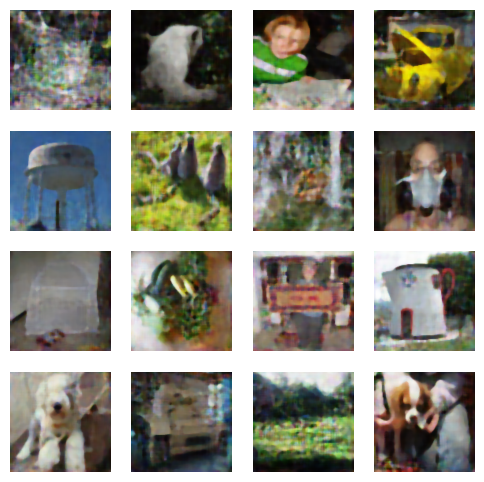

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

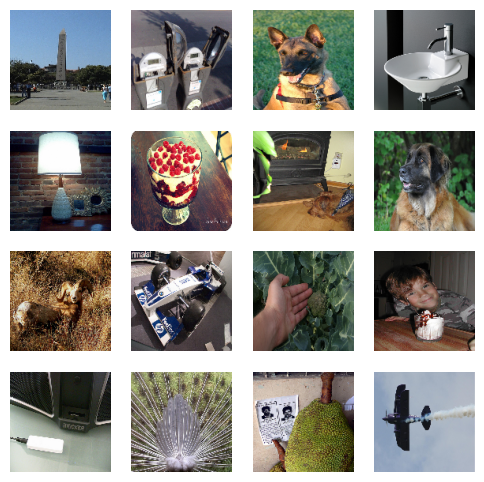

| It: 1 | Loss: -5.1868 | Time:   0.34s |


| It: 1001 | Loss: -60.7513 | Time: 351.63s |


| It: 2001 | Loss: -61.5309 | Time: 354.51s |


| It: 3001 | Loss: -61.6865 | Time: 353.32s |


| It: 4001 | Loss: -61.7879 | Time: 352.14s |


| It: 5001 | Loss: -61.8415 | Time: 352.79s |


| It: 6001 | Loss: -61.8860 | Time: 352.78s |


| It: 7001 | Loss: -61.9180 | Time: 354.00s |


| It: 8001 | Loss: -61.9367 | Time: 350.06s |


| It: 9001 | Loss: -61.9453 | Time: 354.58s |


| It: 1 | Loss: -3.6826 | Time:   0.39s |


| It: 1001 | Loss: -60.6183 | Time: 349.41s |


| It: 2001 | Loss: -61.5013 | Time: 343.45s |


| It: 3001 | Loss: -61.6823 | Time: 353.48s |


| It: 4001 | Loss: -61.7797 | Time: 354.82s |


| It: 5001 | Loss: -61.8412 | Time: 352.87s |


| It: 6001 | Loss: -61.8850 | Time: 354.63s |


| It: 7001 | Loss: -61.9161 | Time: 355.65s |


| It: 8001 | Loss: -61.9354 | Time: 354.23s |


| It: 9001 | Loss: -61.9446 | Time: 351.84s |


| It: 1 | Loss: -8.4206 | Time:   0.39s |


| It: 1001 | Loss: -60.6523 | Time: 357.68s |


| It: 2001 | Loss: -61.4869 | Time: 357.39s |


| It: 3001 | Loss: -61.6844 | Time: 360.04s |


| It: 4001 | Loss: -61.7838 | Time: 364.98s |


| It: 5001 | Loss: -61.8433 | Time: 371.13s |


| It: 6001 | Loss: -61.8874 | Time: 369.79s |


| It: 7001 | Loss: -61.9187 | Time: 371.15s |


| It: 8001 | Loss: -61.9382 | Time: 366.84s |


| It: 9001 | Loss: -61.9466 | Time: 369.41s |


| It: 1 | Loss: -13.6035 | Time:   0.40s |


| It: 1001 | Loss: -60.6417 | Time: 365.86s |


| It: 2001 | Loss: -61.4657 | Time: 363.68s |


| It: 3001 | Loss: -61.6770 | Time: 363.95s |


| It: 4001 | Loss: -61.7642 | Time: 365.38s |


| It: 5001 | Loss: -61.8324 | Time: 365.55s |


| It: 6001 | Loss: -61.8736 | Time: 362.75s |


| It: 7001 | Loss: -61.9104 | Time: 363.40s |


| It: 8001 | Loss: -61.9308 | Time: 365.28s |


| It: 9001 | Loss: -61.9406 | Time: 356.53s |


| It: 1 | Loss: -6.3484 | Time:   0.37s |


| It: 1001 | Loss: -60.9342 | Time: 364.86s |


| It: 2001 | Loss: -61.5669 | Time: 364.95s |


| It: 3001 | Loss: -61.7175 | Time: 364.61s |


| It: 4001 | Loss: -61.7976 | Time: 364.05s |


| It: 5001 | Loss: -61.8532 | Time: 362.98s |


| It: 6001 | Loss: -61.8949 | Time: 364.82s |


| It: 7001 | Loss: -61.9246 | Time: 364.97s |


| It: 8001 | Loss: -61.9418 | Time: 364.88s |


| It: 9001 | Loss: -61.9504 | Time: 364.44s |


BEST PSNR: 20.3210
MEDIAN PSNR: 19.6949
ALL PSNR: [18.7214, 19.2648, 19.9041, 20.3210, 20.3210]


<Figure size 400x300 with 0 Axes>

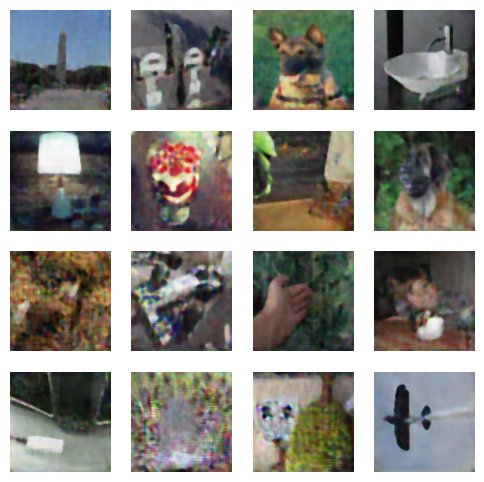

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

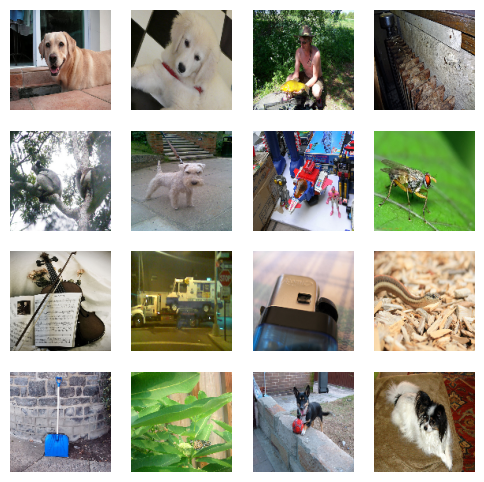

| It: 1 | Loss: -5.6210 | Time:   0.40s |


| It: 1001 | Loss: -61.3010 | Time: 362.39s |


| It: 2001 | Loss: -61.7015 | Time: 363.25s |


| It: 3001 | Loss: -61.8109 | Time: 362.40s |


| It: 4001 | Loss: -61.8646 | Time: 358.65s |


| It: 5001 | Loss: -61.9028 | Time: 360.81s |


| It: 6001 | Loss: -61.9296 | Time: 359.97s |


| It: 7001 | Loss: -61.9489 | Time: 362.95s |


| It: 8001 | Loss: -61.9610 | Time: 362.22s |


| It: 9001 | Loss: -61.9664 | Time: 359.97s |


| It: 1 | Loss: -3.3558 | Time:   0.40s |


| It: 1001 | Loss: -61.1693 | Time: 365.36s |


| It: 2001 | Loss: -61.6746 | Time: 363.35s |


| It: 3001 | Loss: -61.7987 | Time: 362.84s |


| It: 4001 | Loss: -61.8604 | Time: 364.09s |


| It: 5001 | Loss: -61.8977 | Time: 360.55s |


| It: 6001 | Loss: -61.9262 | Time: 361.95s |


| It: 7001 | Loss: -61.9472 | Time: 360.65s |


| It: 8001 | Loss: -61.9596 | Time: 363.17s |


| It: 9001 | Loss: -61.9655 | Time: 359.77s |


| It: 1 | Loss: -4.3455 | Time:   0.39s |


| It: 1001 | Loss: -61.2429 | Time: 360.52s |


| It: 2001 | Loss: -61.6902 | Time: 366.98s |


| It: 3001 | Loss: -61.8127 | Time: 358.19s |


| It: 4001 | Loss: -61.8647 | Time: 361.16s |


| It: 5001 | Loss: -61.9034 | Time: 359.00s |


| It: 6001 | Loss: -61.9293 | Time: 364.69s |


| It: 7001 | Loss: -61.9496 | Time: 364.34s |


| It: 8001 | Loss: -61.9614 | Time: 362.82s |


| It: 9001 | Loss: -61.9668 | Time: 362.97s |


| It: 1 | Loss: -16.8237 | Time:   0.39s |


| It: 1001 | Loss: -61.3211 | Time: 362.02s |


| It: 2001 | Loss: -61.7225 | Time: 365.84s |


| It: 3001 | Loss: -61.8188 | Time: 364.71s |


| It: 4001 | Loss: -61.8740 | Time: 364.35s |


| It: 5001 | Loss: -61.9092 | Time: 364.71s |


| It: 6001 | Loss: -61.9347 | Time: 356.05s |


| It: 7001 | Loss: -61.9538 | Time: 362.40s |


| It: 8001 | Loss: -61.9651 | Time: 363.37s |


| It: 9001 | Loss: -61.9703 | Time: 360.46s |


| It: 1 | Loss: -13.0039 | Time:   0.40s |


| It: 1001 | Loss: -61.3905 | Time: 364.17s |


| It: 2001 | Loss: -61.7150 | Time: 359.60s |


| It: 3001 | Loss: -61.8156 | Time: 362.68s |


| It: 4001 | Loss: -61.8717 | Time: 361.81s |


| It: 5001 | Loss: -61.9080 | Time: 362.98s |


| It: 6001 | Loss: -61.9323 | Time: 365.45s |


| It: 7001 | Loss: -61.9521 | Time: 362.42s |


| It: 8001 | Loss: -61.9632 | Time: 364.75s |


| It: 9001 | Loss: -61.9685 | Time: 366.72s |


BEST PSNR: 20.9402
MEDIAN PSNR: 20.1346
ALL PSNR: [19.4094, 19.7212, 20.9402, 19.7144, 19.7144]


<Figure size 400x300 with 0 Axes>

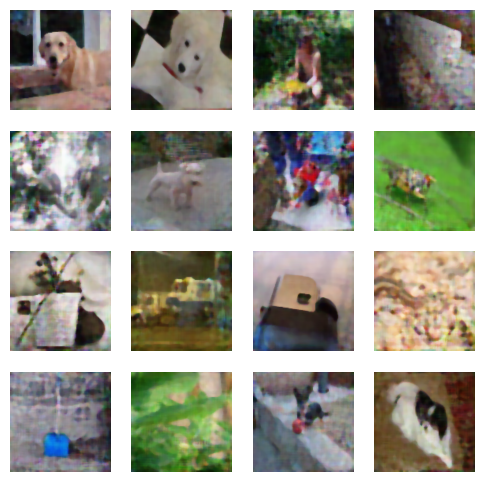

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

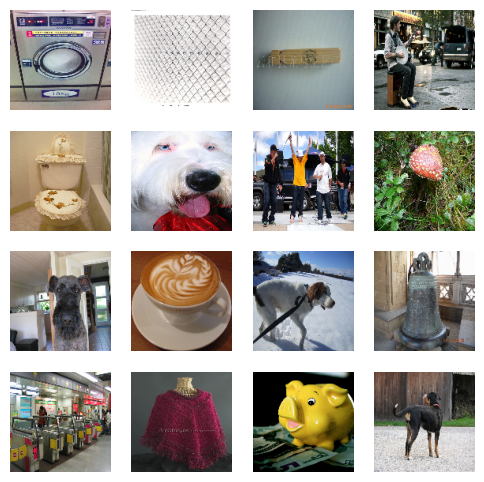

| It: 1 | Loss: -7.6260 | Time:   0.37s |


| It: 1001 | Loss: -61.1226 | Time: 364.51s |


| It: 2001 | Loss: -61.6581 | Time: 364.01s |


| It: 3001 | Loss: -61.7825 | Time: 364.45s |


| It: 4001 | Loss: -61.8486 | Time: 361.04s |


| It: 5001 | Loss: -61.8902 | Time: 363.89s |


| It: 6001 | Loss: -61.9201 | Time: 362.28s |


| It: 7001 | Loss: -61.9428 | Time: 362.59s |


| It: 8001 | Loss: -61.9563 | Time: 362.80s |


| It: 9001 | Loss: -61.9622 | Time: 362.36s |


| It: 1 | Loss: -12.9188 | Time:   0.40s |


| It: 1001 | Loss: -60.7104 | Time: 362.41s |


| It: 2001 | Loss: -61.5724 | Time: 362.98s |


| It: 3001 | Loss: -61.7299 | Time: 362.45s |


| It: 4001 | Loss: -61.8198 | Time: 363.05s |


| It: 5001 | Loss: -61.8696 | Time: 362.67s |


| It: 6001 | Loss: -61.9071 | Time: 360.54s |


| It: 7001 | Loss: -61.9316 | Time: 349.37s |


| It: 8001 | Loss: -61.9464 | Time: 368.73s |


| It: 9001 | Loss: -61.9539 | Time: 366.11s |


| It: 1 | Loss: -11.8432 | Time:   0.40s |


| It: 1001 | Loss: -61.0428 | Time: 369.24s |


| It: 2001 | Loss: -61.6348 | Time: 367.34s |


| It: 3001 | Loss: -61.7767 | Time: 348.98s |


| It: 4001 | Loss: -61.8425 | Time: 346.89s |


| It: 5001 | Loss: -61.8836 | Time: 344.88s |


| It: 6001 | Loss: -61.9175 | Time: 346.10s |


| It: 7001 | Loss: -61.9395 | Time: 348.57s |


| It: 8001 | Loss: -61.9528 | Time: 342.15s |


| It: 9001 | Loss: -61.9588 | Time: 340.26s |


| It: 1 | Loss: -8.8659 | Time:   0.35s |


| It: 1001 | Loss: -61.0342 | Time: 346.26s |


| It: 2001 | Loss: -61.6181 | Time: 348.86s |


| It: 3001 | Loss: -61.7768 | Time: 342.96s |


| It: 4001 | Loss: -61.8432 | Time: 348.22s |


| It: 5001 | Loss: -61.8865 | Time: 347.06s |


| It: 6001 | Loss: -61.9176 | Time: 348.39s |


| It: 7001 | Loss: -61.9397 | Time: 347.39s |


| It: 8001 | Loss: -61.9532 | Time: 343.99s |


| It: 9001 | Loss: -61.9595 | Time: 350.42s |


| It: 1 | Loss: -8.9570 | Time:   0.36s |


| It: 1001 | Loss: -60.7004 | Time: 347.58s |


| It: 2001 | Loss: -61.5633 | Time: 348.20s |


| It: 3001 | Loss: -61.7406 | Time: 349.57s |


| It: 4001 | Loss: -61.8264 | Time: 348.28s |


| It: 5001 | Loss: -61.8732 | Time: 348.16s |


| It: 6001 | Loss: -61.9097 | Time: 348.24s |


| It: 7001 | Loss: -61.9331 | Time: 345.46s |


| It: 8001 | Loss: -61.9491 | Time: 347.47s |


| It: 9001 | Loss: -61.9556 | Time: 345.55s |


BEST PSNR: 20.0284
MEDIAN PSNR: 19.1979
ALL PSNR: [18.7806, 19.0885, 19.6142, 18.4777, 18.4777]


<Figure size 400x300 with 0 Axes>

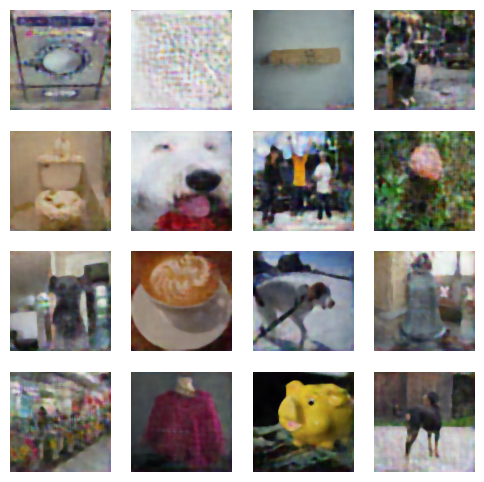

In [9]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)